# Lab1. Exploratory Data Analysis (Optional)

These series of notebooks will dectect anomalies from clickstream dataset. We will use fake dataset that fascimile real clickstream data in `data` folder. There are 4 notebooks and you can go to any notebook in any order. However, it is recommended to run it sequentially from 1 to 4. 

This notebook is for the EDA. (exploratory data analysis) We will explore data to undersand what is in the dataset. 

## Table Of Contents
1. unzipping compressed files
1. Exploring data

This notebook code was tested with SageMaker SDK 2.20

In [1]:
# !pip install -U sagemaker==2.20

Import the libraries related to data exploration and preparation that are used in this lesson.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import boto3
import botocore
import sagemaker
import sys

from util import *

## 1. Unzipping compressed files


In [3]:
data_dir='data'
!tar -zxvf $data_dir/data.tar.gz 
# !rm data/data.tar.gz

data/
data/fault_label_1T.csv
data/clicks_1T.csv
data/clicks.csv
data/.ipynb_checkpoints/
data/clicks_10T.csv
data/fault_label_10T.csv


There are 5 files as below.
- `clicks.csv` : Raw clickstream logs with simulated fault events
- `clicks_1T.csv` : Resampled clickstream by 1 minuties.
- `clicks_10T.csv` : Resampled clickstream by 10 minuties.
- `fault_label_1T.csv` : Anomaly label for `clicks_1T.csv`
- `fault_label_10T.csv` : Anomaly label for `clicks_10T.csv`

For the experiment, data was slightly transformed from `clicks.csv`.
You can refer to [fakets.ipynb](fakets.ipynb) file in the same folder to see the code generating these files .

## 2. Exploring data

### Raw clickstream logs

To begin, read the `clicks.csv` file first. The clickstream occured every few seconds from Jun 7th, 2020 to Jun 15th, 2020. 

In [5]:
clicks = pd.read_csv(data_dir + '/clicks.csv')
clicks['timestamp'] = clicks['timestamp'].astype('datetime64')
clicks.head(5)

,timestamp,page,user,session_id
0,2020-07-07 08:41:58,p03,u0000000001,2020-07-07 08:41:58 ; p03 ; u0000000001
1,2020-07-07 08:11:32,p02,u0000000001,2020-07-07 08:11:32 ; p02 ; u0000000001
2,2020-07-08 18:55:30,p00,u0000000001,2020-07-08 18:55:30 ; p00 ; u0000000001
3,2020-07-09 00:06:18,p19,u0000000001,2020-07-09 00:06:18 ; p19 ; u0000000001
4,2020-07-09 00:19:34,p00,u0000000001,2020-07-09 00:19:34 ; p00 ; u0000000001


In [6]:
print(clicks['timestamp'].agg([min,max]))

min   2020-07-07 00:00:00
max   2020-07-15 23:59:35
Name: timestamp, dtype: datetime64[ns]


### Clickstream by 10 minutes

`clicks_10T.csv` file has clickstream with some errors.
- Data was resampled by 10 mimutes from original raw click logs and counts pages, users, and clicks by 10 minutes. 
- There were 3 program fault events during 9 days.(For some reason, a program error occured that does not detect user information correctly so the number of users droped irregularly.)
- There were 5 system fault events during 9 days.(For some reason, a system error occured and users couldn't reach the target web page. So, both the number of clicks and users droped irregularly.)

In [9]:
clicks_10T = pd.read_csv(data_dir + '/clicks_10T.csv', parse_dates=['timestamp']).set_index('timestamp')
clicks_10T['fault'] = pd.read_csv(data_dir + '/fault_label_10T.csv', header=None).values[0]
clicks_10T.head()

,page,user,click,fault
timestamp,,,,
2020-07-07 00:00:00,12,78,103,0
2020-07-07 00:10:00,14,76,108,0
2020-07-07 00:20:00,15,66,93,0
2020-07-07 00:30:00,15,71,102,0
2020-07-07 00:40:00,14,75,101,0


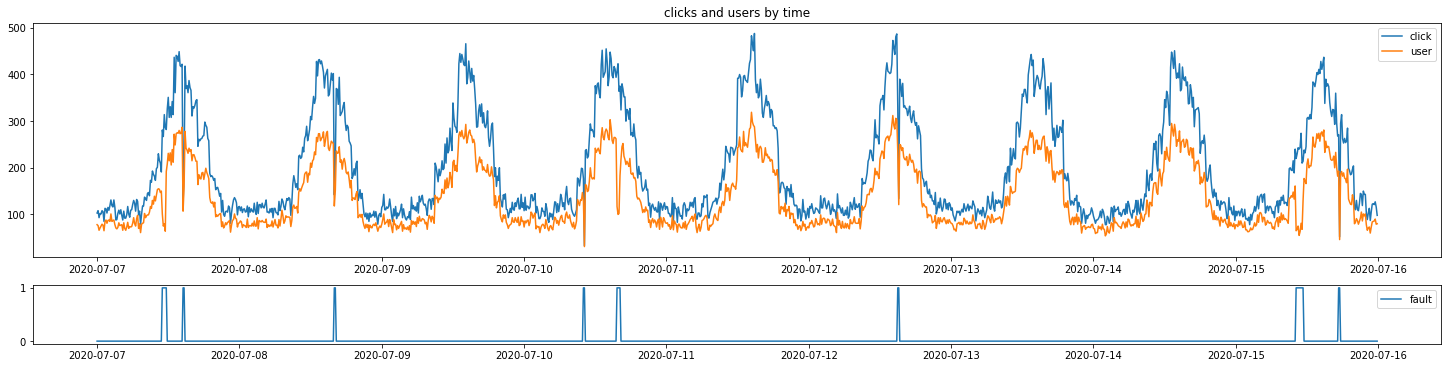

In [14]:
def plot_click_w_fault(df, start_dt=None, end_dt=None):
    start_dt = df.index[0] if start_dt is None else start_dt
    end_dt   = df.index[-1] if end_dt is None else end_dt
    
    fig = plt.figure(constrained_layout=True, figsize=(20,5))
    spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[4,1])
    ax1 = fig.add_subplot(spec[0,0])
    ax1.plot(df[['click','user']][start_dt:end_dt])
    ax1.legend(['click','user'])
    ax1.set_title('clicks and users by time')
    ax2 = fig.add_subplot(spec[1,0])
    ax2.plot(df['fault'][start_dt:end_dt])
    ax2.legend(['fault'])
    plt.show()

plot_click_w_fault(clicks_10T)

Zoom into around 15th Jul 2020. Around 10 AMof July 15th, there was an unusual drop in users. (We will try to find these events in following notebooks.)

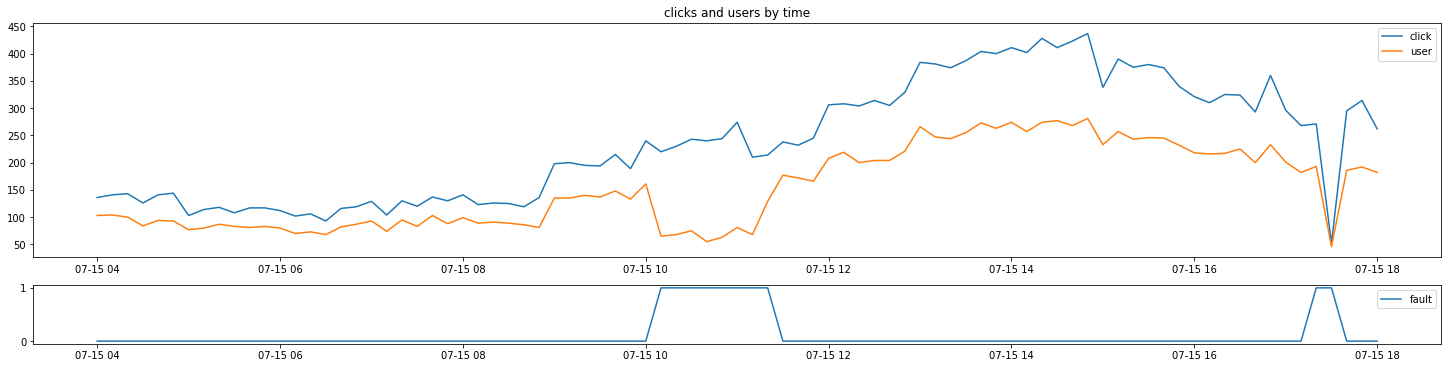

In [15]:
new_date = pd.date_range('2020-07-15 04:00:00','2020-07-15 18:00:00',freq='10T')
plot_click_w_fault(clicks_10T, start_dt = new_date[0], end_dt = new_date[-1])

### Clickstream by 1 minute

In the same way, plot the `clicks_1T.csv` resampled by 1 minute.

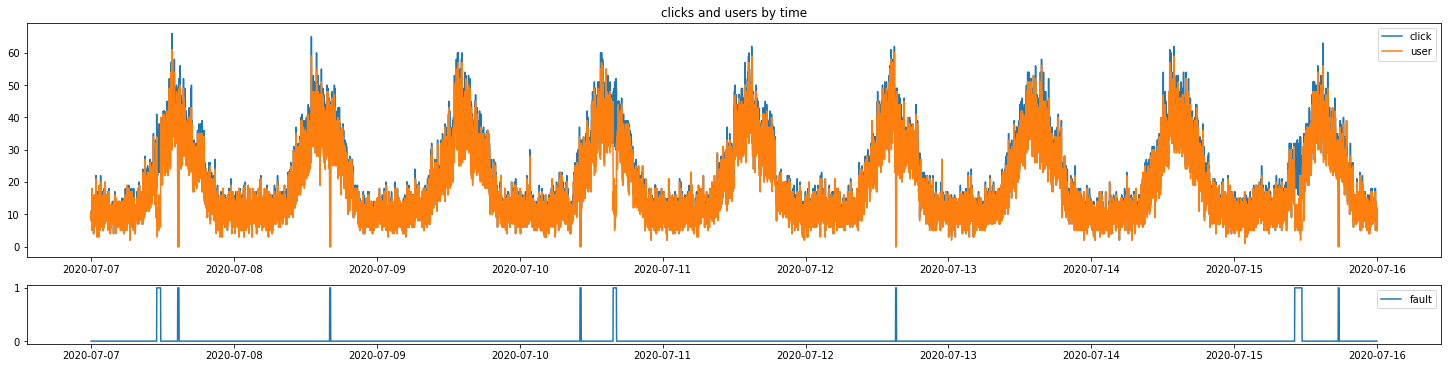

In [16]:
clicks_1T = pd.read_csv(data_dir + '/clicks_1T.csv', parse_dates=['timestamp']).set_index('timestamp')
clicks_1T['fault'] = pd.read_csv(data_dir + '/fault_label_1T.csv', header=None).values[0]

plot_click_w_fault(clicks_1T)

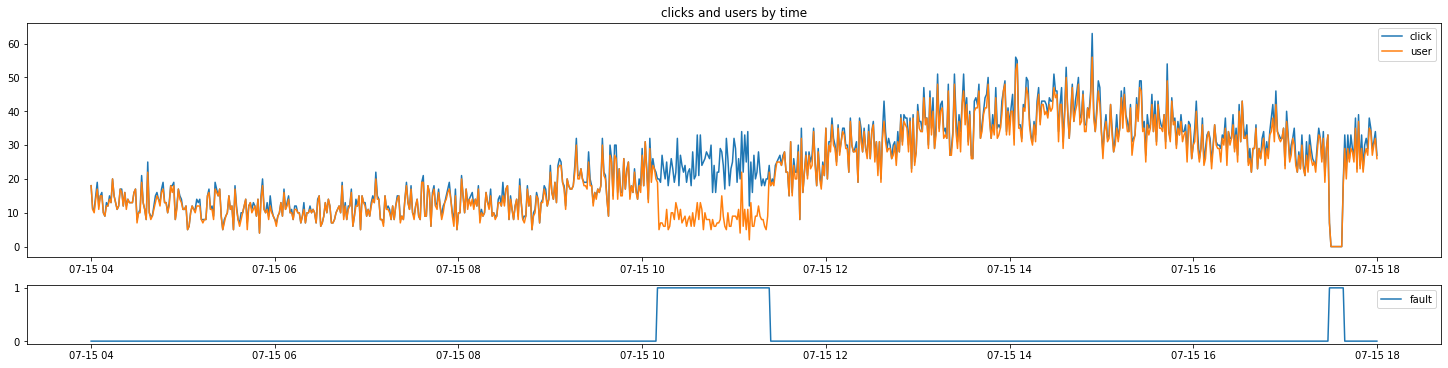

In [17]:
new_date = pd.date_range('2020-07-15 04:00:00','2020-07-15 18:00:00',freq='1T')
plot_click_w_fault(clicks_1T, start_dt = new_date[0], end_dt = new_date[-1])

### Plotting clicks by page

Plot clickstream by page to check the patterns. 

In [18]:
def resample_click_by_page(clickstream_cnt, page, freq='10T'):
    resampling_clickstream = clickstream_cnt.set_index('timestamp').resample(freq)
    clickstream_resample = {'user':resampling_clickstream.nunique()['user']}
    clickstream_resample.update({'click':resampling_clickstream.count()['session_id']})
    clickstream_resample.update({'page':page})
    
    return clickstream_resample

def plot_click_by_page(df):
    plt.figure(figsize=(20,12))
    freq='1H'

    pages = df['page'].unique()
    clickstream_cnt = df.groupby(['timestamp', 'page']).count().reset_index()
    click_by_page = []
    for page in pages:
        filtered_click = clickstream_cnt[clickstream_cnt['page']==page]
        click_by_page.append(resample_click_by_page(filtered_click, page, freq=freq))

    xticks = np.arange(min(click_by_page[0]['click'].index), max(click_by_page[0]['click'].index), int(5e11))

    for index, cbp in enumerate(click_by_page):
        plt.subplot(4,5,index+1)
        plt.plot(cbp['click'])
        plt.title(cbp['page'])
        plt.xticks(xticks)

Clicks show similar cyclic patterns on each page except for amplitude.

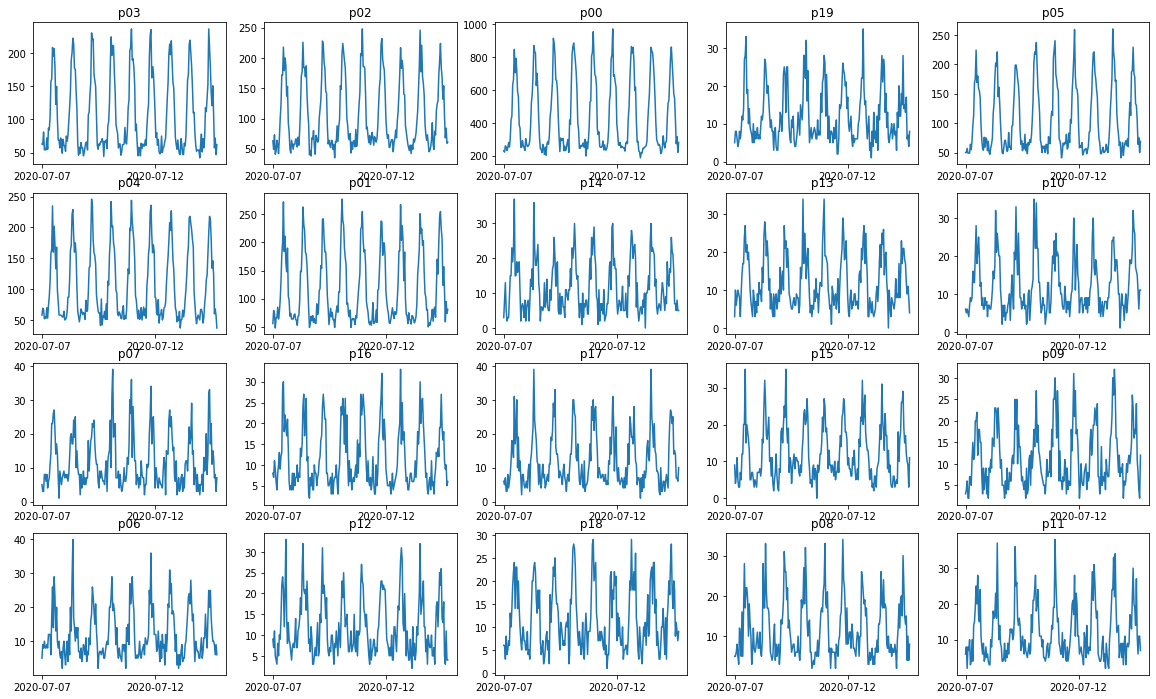

In [19]:
plot_click_by_page(clicks)

Some of functions used in this notebook are stored in the `util.py` file. 